#### Authors: Thomas Bringer, Tapopriya Majumdar, Keshav Mathur & Alexandre Marcil

In [1]:
import numpy as np
from keras.datasets import fashion_mnist

circles = np.loadtxt('circles.txt')

Using TensorFlow backend.


In [0]:
#The following cell has been adapted from the webpage : https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb 
#to help in displaying the decision boundry plots for the trained network.


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib  


def contour_plot(train_inputs, train_labels, predict, hyper_vec):
    """The following function helps with the plots of the decision boundaries
    To call the plot function: contour_plot(<2-D training data>, <corresponding labels>, 
    lambda pred_data:<NNclassName>.<NNPredictFunc>(pred_data),<array of hyper params>)"""
    
    %matplotlib inline
    matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
    
    dh, alpha, epochs, l11,l12,l21,l22 = hyper_vec
    
    subtitle_str = "Hidden Units= %d; StepSize= %.3f; Max Epochs= %d, L11= %.3f; L12= %.3f ;L21= %.3f ;L22= %.3f"%(dh,alpha,epochs,l11,l12,l21,l22)
    #subtitle_str = "Hidden Units= %f; StepSize= %d"%(dh,dh)
    plt.suptitle("Decision boundary for Circles dataset", fontsize=18, ha='center')
    plt.title(subtitle_str,fontsize = 10, ha= 'center')
    #plt.suptitle(("Hidden Units= ",dh,"; L11= ",l11,";L12= ",l12, ";L21= ", l21,";L22= ",l22,";Epochs= ",epochs,) fontsize=8, ha='center')
    plt.xlabel("x(1)")
    plt.ylabel("x(2)")
    
    # Set min and max values and give it some padding
    x_min, x_max = train_inputs[:, 0].min() - .5, train_inputs[:, 0].max() + .5
    y_min, y_max = train_inputs[:, 1].min() - .5, train_inputs[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral )#cmap=plt.cm.plasma)
    plt.scatter(train_inputs[:,0], train_inputs[:,1], s=5, c=train_labels, cmap=plt.cm.Spectral)


def error_plots(train_err,cv_err,test_err, xs,hyper_vec):
    """Function to plot the train, CV, and test errors for a given
    hyperparameter value(s). The function call is as follows: error_plots(<training error values>,
    <CV error values>, <Test error values>, <x-axis variable against which data is plotted>, <set of hyperparamters.>)"""
    # plot
    plt.figure(figsize=(25,15))
    plt.plot(xs, train_err, 'r--', linewidth=3, label='Training error')
    plt.plot(xs, cv_err, 'b--', linewidth=3, label='Croos-validation err')
    plt.plot(xs, test_err, 'g--', linewidth=3, label='Test error')
    #plt.plot(xs, parzen3_density, 'k-', linewidth=5, label='Parzen Kernel w/ Appropriate $\sigma^2$')
    
    dh, alpha, epochs, l11,l12,l21,l22 = hyper_vec
    subtitle_str = "Hidden Units= %d; StepSize= %.3f; Epochs= %d, L11= %.3f; L12= %.3f ;L21= %.3f ;L22= %.3f"%(dh,alpha,epochs,l11,l12,l21,l22)
    plt.suptitle("ErrorPlots", fontsize=18, ha='center')
    plt.title(subtitle_str,fontsize = 10, ha= 'center')
   
    plt.figtext(0.5, 0.9, "Error plots", fontsize=35, ha='center')
    plt.legend(loc=2, prop={'size': 24})
    plt.show()

In [0]:
### Splitting the circles dataset

import random 
random.seed(3456)
train_ratio=0.75

# Randomize indices for train and test set.
inds = list(range(circles.shape[0]))
random.shuffle(inds)
n_train=round(circles.shape[0]*train_ratio)
train_inds = inds[:n_train]
test_inds  = inds[n_train:]

train_set = circles[train_inds,:]
test_set  = circles[test_inds,:]

# Separarer l'ensemble de train et test dans les entrees et les etiquettes
train_inputs = train_set[:, :-1]
train_labels = train_set[:, -1].astype('int32')
test_inputs  = test_set [:, :-1]
test_labels  = test_set [:, -1].astype('int32') 


In [0]:
# stablesoftmax implementation
def logits_exp(X):
    X_max = np.max(X,axis=0,keepdims=True)
    exp_x = np.exp(X-X_max)
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)


### The following is the implementation of a neural network class which loops over different inputs

In [0]:
class NeuralNetworkLoop:
    """Our implementation of a Neural Network"""
    
    def __init__(self, dh,  alpha=1e-2, tol=1e-10,
                 batch_size=32, n_epochs=500, lambda11=0, 
                 lambda12=0, lambda21=0, lambda22=0):
        self._is_trained = False
        self._dh = dh  #hidden layer size
        self._alpha = alpha 
        self._tol = tol
        self._K = batch_size
        self._n_epochs = n_epochs
        self._l11 = lambda11
        self._l12 = lambda12
        self._l21 = lambda21
        self._l22 = lambda22
        self.hyper_vec = [self._dh, self._alpha, self._n_epochs, self._l11, self._l12, self._l21, self._l22] 
        
    def _initialise_params(self, d=0, m=0,set_W =0):
        
        assert d !=0, "No I/P available"
        assert m != 0, "No labels available"
        
        self._d = d #I/p dimensions
        self._m = m  #No. of classes
                
        self._W1 = np.random.uniform(-(self._d ** (-0.5)), 
                                     self._d ** (-0.5), 
                                     (self._dh, self._d))
        
        self._W2 = np.random.uniform(-(self._dh ** (-0.5)), 
                                     self._dh ** (-0.5), 
                                     (self._m, self._dh))   

        self._b1 = np.zeros((self._dh, 1))
        self._b2 = np.zeros((self._m, 1))
        
        if set_W ==1:
            
            self._W1 = np.array([[.01,.012],[.003, .0025]])
            self._W2 = np.array([[.001,.029],[.0034, .05]])

                
        
    def __str__(self):
        """String representation of the parameters"""
        assert self._is_trained
        return "b1 = %r, W1 = %s, b2 = %r, W2 = %s" % \
            (
            str(np.round(self._b1, 3)).replace('\n', ''), 
            str(np.round(self._W1, 3)).replace('\n', ''),
            str(np.round(self._b2, 3)).replace('\n', ''),
            str(np.round(self._W2, 3)).replace('\n', '')
            )

    def L(self, X, y):
        """Calculate loss function for multiple entries"""
        n = X.shape[0]
        return \
         -np.log(logits_exp(self._W2 @ np.maximum(self._W1 @ X.T + self._b1, 0) + self._b2)[y, range(n)])

    def predict(self, X):
        """Predicts the classes for the test data"""
        sm = logits_exp(self._W2 @ np.maximum(self._W1 @ X.T + self._b1, 0) + self._b2)
        return np.argmax(sm, axis=0)

    def accuracy(self, X, y):
        return np.sum(self.predict(X) == y) / len(y)

    def fit_loop(self, X, y, loss_plot=False):
        assert X.shape[0] == len(y), "Size mismatch!"
        
        n, d = X.shape
        
        self._initialise_params(d,max(1+max(y),2))
        
        assert np.all(0 <= y) and np.all(y <= self._m-1), "Check labels!"
        
        l = 0
        loss_values = []
        n_minibatches = 1 + (n // self._K)
        
        while True:
            for i in range(n_minibatches):
                if i*self._K >= X.shape[0]:
                    continue
                X_batch = X[i*self._K:(i+1)*self._K]
                y_batch = y[i*self._K:(i+1)*self._K]
                old_b1, old_W1, old_b2, old_W2 = \
                        self._b1.copy(), self._W1.copy(), \
                        self._b2.copy(), self._W2.copy()
                grads_b1, grads_W1, grads_b2, grads_W2 = \
                            self._loop_backprop_grad(X_batch, y_batch)
                self._b1 -= self._alpha * np.mean(grads_b1, axis=0)
                self._W1 -= self._alpha * (np.mean(grads_W1, axis=0)
                                           + self._l11 * np.sign(self._W1)
                                           + self._l12 * 2 * self._W1)
                self._b2 -= self._alpha * np.mean(grads_b2, axis=0)                
                self._W2 -= self._alpha * (np.mean(grads_W2, axis=0)
                                           + self._l21 * np.sign(self._W2)
                                           + self._l22 * 2 * self._W2)
                
                if i==0 and l%1000 ==0 :
                    loss_values.append(np.mean(self.L(X,y)) )
                    print(l,'.LOSS:', loss_values[-1])
                
                # convergence
                if loss_values[-1] == np.inf:
                    print("Loss at inf")
                    self._is_trained = True
                    break
                if np.all(np.abs(self._b1 - old_b1) < self._tol) \
                    & np.all(np.abs(self._W1 - old_W1) < self._tol) \
                    & np.all(np.abs(self._b2 - old_b2) < self._tol) \
                    & np.all(np.abs(self._W2 - old_W2) < self._tol):
                    self._is_trained = True
                    print("converged after minibatch %d in iter %d" % ((i+1), (l+1)))
                    
                    break
            if self._is_trained:
                break
            if l > self._n_epochs:
                print("maximum epochs reached. Exiting...")
                self._is_trained = True
                break
            l += 1
        
        if loss_plot:
            pass
          #Add plot func

    def _single_backprop_grad(self, data, label):
        """
        calculate parameter gradients using 
        backpropagation for a single data point
        """
        assert len(data) == self._d, "Size mismatch!"
        assert 0 <= label <= self._m-1, "Check label!"
        
        # convert data to a column vector and
        # do forward prop
        ha = self._W1 @ data.reshape(-1,1) + self._b1  
        hs = np.maximum(ha, 0)
        oa = self._W2 @ hs + self._b2
        os = logits_exp(oa)
        
        # do back prop to find gradient
        grad_oa = os - np.eye(self._m)[:, label:(label+1)]  # onehot label
        grad_b2 = grad_oa
        grad_W2 = grad_oa @ hs.T
        grad_hs = self._W2.T @ grad_oa
        grad_ha = grad_hs * (ha > 0)
        grad_b1 = grad_ha
        grad_W1 = grad_ha @ data.reshape(1,-1)  # data^ T
        return grad_b1, grad_W1, grad_b2, grad_W2

    def _loop_backprop_grad(self, X, y):
        """
        calculate parameter gradients using 
        backpropagation for a single data point
        """
        n = X.shape[0]
        assert n == len(y), "Size mismatch!"
        assert np.all(0 <= y) and np.all(y <= self._m-1), "Check labels!"
        # storing the gradients in 3-d arrays
        grads_b1 = np.zeros((n, self._dh, 1))
        grads_W1 = np.zeros((n, self._dh, self._d))
        grads_b2 = np.zeros((n, self._m, 1))
        grads_W2 = np.zeros((n, self._m, self._dh))

        for i in range(X.shape[0]):
            gr_b1, gr_W1, gr_b2, gr_W2 = \
                    self._single_backprop_grad(X[i], y[i])
            grads_b1[i] = gr_b1
            grads_W1[i] = gr_W1
            grads_b2[i] = gr_b2
            grads_W2[i] = gr_W2

        return grads_b1, grads_W1, grads_b2, grads_W2

    def compare_gradients(self, X, y,set_W=0):
        assert X.shape[0] == len(y), "Size mismatch!"
        
        
        self._initialise_params(X.shape[1],max(max(y)+1,2),set_W)
        
        assert np.all(0 <= y) and np.all(y <= self._m-1), "Check labels!"
        bools = np.zeros(X.shape[0]).astype(np.bool)
        
        bp_gradb1_tot = np.zeros(self._b1.shape)
        bp_gradW1_tot = np.zeros(self._W1.shape)
        bp_gradb2_tot = np.zeros(self._b2.shape)
        bp_gradW2_tot = np.zeros(self._W2.shape)
        
        fd_gradb1_tot = np.zeros(self._b1.shape)
        fd_gradW1_tot = np.zeros(self._W1.shape)
        fd_gradb2_tot = np.zeros(self._b2.shape)
        fd_gradW2_tot = np.zeros(self._W2.shape)
        
        for i in range(X.shape[0]):
            # grad using backpropagation
            bp_gr_b1, bp_gr_W1, bp_gr_b2, bp_gr_W2 = \
                    self._single_backprop_grad(X[i], y[i])
            
            bp_gradb1_tot += bp_gr_b1
            bp_gradW1_tot += bp_gr_W1
            bp_gradb2_tot += bp_gr_b2
            bp_gradW2_tot += bp_gr_W2
        
            # gradient using difference check
            df_gr_b1, df_gr_W1, df_gr_b2, df_gr_W2 = \
                    self._single_finite_diff_grad(X[i], y[i])
            
            fd_gradb1_tot += df_gr_b1
            fd_gradW1_tot += df_gr_W1
            fd_gradb2_tot += df_gr_b2
            fd_gradW2_tot += df_gr_W2
        
            # create param vectors 
            bp_gr_params = np.hstack([bp_gr_b1.ravel(), bp_gr_W1.ravel(), bp_gr_b2.ravel(), bp_gr_W2.ravel()])
            df_gr_params = np.hstack([df_gr_b1.ravel(), df_gr_W1.ravel(), df_gr_b2.ravel(), df_gr_W2.ravel()])
            # find zero indices
            bp_zero_ind = (bp_gr_params == 0)
            df_zero_ind = (df_gr_params == 0)
            # find ratio of nonzero entries
            non_zero_ratios = np.divide(bp_gr_params[~bp_zero_ind], df_gr_params[~df_zero_ind])
            # check if zero indices are equal and the ratios are close to 1
            bools[i] = np.all(bp_zero_ind == df_zero_ind) and np.all(np.abs(non_zero_ratios - 1) < 0.01)
            
        # True if true for all entries
        
        # create param vectors 
        bp_gr_params = np.hstack([bp_gradb1_tot.ravel(), bp_gradW1_tot.ravel(), bp_gradb2_tot.ravel(), bp_gradW2_tot.ravel()])
        df_gr_params = np.hstack([fd_gradb1_tot.ravel(), fd_gradW1_tot.ravel(), fd_gradb2_tot.ravel(), fd_gradW2_tot.ravel()])
        # find zero indices
        bp_zero_ind = (bp_gr_params == 0)
        df_zero_ind = (df_gr_params == 0)
        # find ratio of nonzero entries
        non_zero_ratios = np.divide(bp_gr_params[~bp_zero_ind], df_gr_params[~df_zero_ind])
        # check if zero indices are equal and the ratios are close to 1
        boolsTot = np.all(bp_zero_ind == df_zero_ind) and np.all(np.abs(non_zero_ratios - 1) < 0.01)
        
        print("All ratios >.99 and <1.01:", np.all(boolsTot))
        
        self.display_gradients(bp_gradb1_tot, bp_gradW1_tot, bp_gradb2_tot, \
                               bp_gradW2_tot, fd_gradb1_tot, fd_gradW1_tot, fd_gradb2_tot, \
                               fd_gradW2_tot)
        return np.all(bools)

    def _single_finite_diff_grad(self, data, label):
        """Finite Difference Gradient Check"""
        assert len(data) == self._d, "Size mismatch!"
        assert 0 <= label <= self._m-1, "Check label!"
        # grad b1
        grad_b1 = np.zeros(self._b1.shape)
        for i in range(self._dh):
            grad_b1[i, 0] = self._finite_diff_partial(data, label, 'b1', i)
        # grad W1
        grad_W1 = np.zeros(self._W1.shape)
        for i in range(self._dh):
            for j in range(self._d):
                grad_W1[i, j] = self._finite_diff_partial(data, label, 'W1', (i, j))
        # grad b2
        grad_b2 = np.zeros(self._b2.shape)
        for i in range(self._m):
            grad_b2[i, 0] = self._finite_diff_partial(data, label, 'b2', i)
        # grad W2
        grad_W2 = np.zeros(self._W2.shape)
        for i in range(self._m):
            for j in range(self._dh):
                grad_W2[i, j] = self._finite_diff_partial(data, label, 'W2', (i, j))
        return grad_b1, grad_W1, grad_b2, grad_W2

    def _finite_diff_partial(self, data, label, var, ind):
        """
        Calculates the finite difference partial derivative
        of the datapoint and label for a given variable and index
        """
        # small number
        eps = np.random.uniform(1e-6, 1e-4)
        # adjust the dimensions to calculate loss function
        X = np.array([data])
        y = np.array([label])
        L2 = self.L(X, y).item()
        if var == 'b1':
            self._b1[ind] += eps
            L1 = self.L(X, y).item()
            self._b1[ind] -= eps
        elif var == 'W1':
            self._W1[ind] += eps
            L1 = self.L(X, y).item()
            self._W1[ind] -= eps
        elif var == 'b2':
            self._b2[ind] += eps
            L1 = self.L(X, y).item()
            self._b2[ind] -= eps
        elif var == 'W2':
            self._W2[ind] += eps
            L1 = self.L(X, y).item()
            self._W2[ind] -= eps
        return (L1-L2) / eps  # (f(x + eps) - f(x)) / eps

    def _loop_finite_diff_grad(self, X, y):
        """
        calculate parameter gradients using 
        finite difference for a single data point
        """
        n = X.shape[0]
        assert n == len(y), "Size mismatch!"
        assert np.all(0 <= y) and np.all(y <= self._m-1), "Check labels!"
        # storing the gradients in 3-d arrays
        grads_b1 = np.zeros((n, self._dh, 1))
        grads_W1 = np.zeros((n, self._dh, self._d))
        grads_b2 = np.zeros((n, self._m, 1))
        grads_W2 = np.zeros((n, self._m, self._dh))
        for i in range(X.shape[0]):
            gr_b1, gr_W1, gr_b2, gr_W2 = \
                    self._single_finite_diff_grad(X[i], y[i])
            grads_b1[i] = gr_b1
            grads_W1[i] = gr_W1
            grads_b2[i] = gr_b2
            grads_W2[i] = gr_W2

        return grads_b1, grads_W1, grads_b2, grads_W2
      

    def display_ratios(self, grad_b1, grad_W1, grad_b2, grad_W2, fd_b1, fd_W1, fd_b2, fd_W2):
        print("Ratios between back-propogation and finite difference gradient values:")
        print("b1 gradient : ")
        print(np.divide( grad_b1,fd_b1))
        print()
        print("W1 gradient : ")
        print(np.divide( grad_W1,fd_W1))
        print()
        print("b2 gradient : ")
        print(np.divide( grad_b2,fd_b2))
        print()
        print("W2 gradient : ")
        print(np.divide( grad_W2,fd_W2))
        print()
    
    def display_gradients(self, grad_b1, grad_W1, grad_b2, grad_W2, fd_b1, fd_W1, fd_b2, fd_W2):
        print("Gradients values:")
        print("1) b1 gradient: ")
        print("back-propagation method: ")
        print(grad_b1)
        print("finite difference method: ")
        print(fd_b1)
        print()
        print("2) W1 gradient: ")
        print("back-propagation method: ")
        print(grad_W1)
        print("finite difference method: ")
        print(fd_W1)
        print()
        print("3) b2 gradient: ")
        print("back-propagation method: ")
        print(grad_b2)
        print("finite difference method: ")
        print(fd_b2)
        print()
        print("4) W2 gradient: ")
        print("back-propagation method: ")
        print(grad_W2)
        print("finite difference method: ")
        print(fd_W2)          
        print()

### Q. 1,2 Verification of single gradient checks

In [139]:
nnet = NeuralNetworkLoop(2 )
nnet.compare_gradients(train_inputs[0:1], train_labels[0:1])

All ratios >.99 and <1.01: True
Gradients values:
1) b1 gradient: 
back-propagation method: 
[[-0.21972496]
 [ 0.        ]]
finite difference method: 
[[-0.21972358]
 [ 0.        ]]

2) W1 gradient: 
back-propagation method: 
[[-0.01880297  0.21891895]
 [ 0.          0.        ]]
finite difference method: 
[[-0.01880294  0.21891982]
 [ 0.          0.        ]]

3) b2 gradient: 
back-propagation method: 
[[-0.42401075]
 [ 0.42401075]]
finite difference method: 
[[-0.42400399]
 [ 0.42401801]]

4) W2 gradient: 
back-propagation method: 
[[-0.25064794  0.        ]
 [ 0.25064794  0.        ]]
finite difference method: 
[[-0.25064691  0.        ]
 [ 0.25065029  0.        ]]



True

### Q 3,4) Gradient verification for a batch

In [19]:
### Q.3 
# Add a hyperparameter for the minibatch size K to allow compute the
# gradients on a minibatch of K examples (in a matrix), by looping over
# the K examples (this is a small addition to your previous code).

### Q.4  (looping calculations)
# Display the gradients for both methods (direct computation and finite
# difference) for a small network (d = 2 and dh = 2) with random
# weights and for a minibatch with 10 examples (you can use examples from
# both classes from the two circles dataset).

nnet = NeuralNetworkLoop(2, batch_size=10)
nnet.compare_gradients(train_inputs[:10], train_labels[:10]) 

All ratios >.99 and <1.01: True
Gradients values:
1) b1 gradient: 
back-propagation method: 
[[ 1.92342194]
 [-0.28940959]]
finite difference method: 
[[ 1.92348094]
 [-0.28940065]]

2) W1 gradient: 
back-propagation method: 
[[-1.0540593  -1.5157406 ]
 [-0.29775654  0.10160011]]
finite difference method: 
[[-1.05402742 -1.51571803]
 [-0.29775422  0.10160659]]

3) b2 gradient: 
back-propagation method: 
[[-2.67660696]
 [ 2.67660696]]
finite difference method: 
[[-2.67654693]
 [ 2.67668482]]

4) W2 gradient: 
back-propagation method: 
[[-0.6474672  -0.16976093]
 [ 0.6474672   0.16976093]]
finite difference method: 
[[-0.64745918 -0.16975964]
 [ 0.64746971  0.16976117]]



True

### Q 5. Training the neural network for circles data set

0 .LOSS: 0.6967569390228222
1000 .LOSS: 0.6669629859144226
2000 .LOSS: 0.6337742694759407
3000 .LOSS: 0.6060138044108259
4000 .LOSS: 0.5840330200017585
5000 .LOSS: 0.5701362582079973
maximum epochs reached. Exiting...
Train accuracy: 0.6666666666666666
Test accuracy: 0.6836363636363636


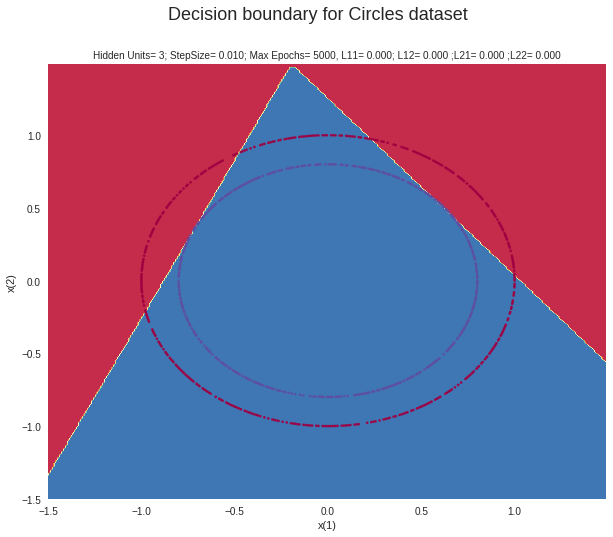

In [105]:
nnet = NeuralNetworkLoop(3, batch_size = 100,n_epochs=5e3, alpha = .01, tol = 1e-4)
nnet.fit_loop(train_inputs, train_labels) 
print("Train accuracy:",nnet.accuracy(train_inputs, train_labels))
print("Test accuracy:",nnet.accuracy(test_inputs, test_labels))

contour_plot(train_inputs, train_labels, lambda x: nnet.predict(x),nnet.hyper_vec)



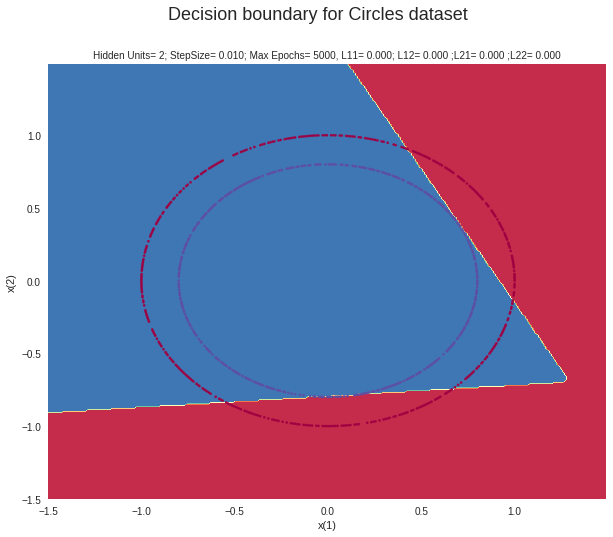

In [104]:
contour_plot(train_inputs, train_labels, lambda x: nnet.predict(x), nnet.hyper_vec)
plt.savefig('test1')

0 .LOSS: 0.70052236558191
maximum epochs reached. Exiting...
Train accuracy: 0.6242424242424243
Test accuracy: 0.6436363636363637


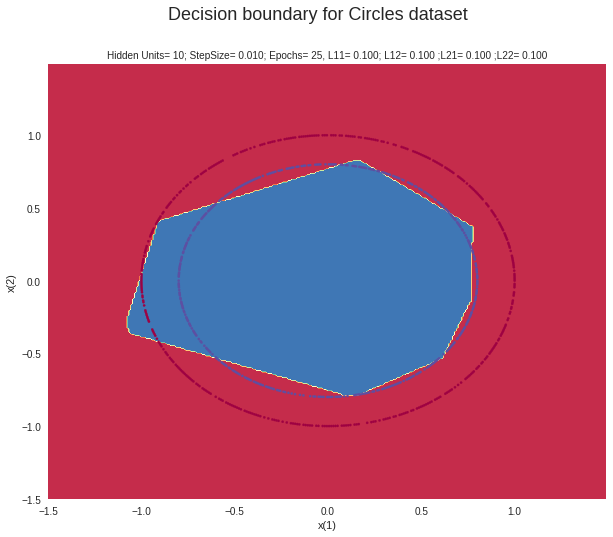

In [217]:

nnetMatLoop = NeuralNetworkLoop(10, batch_size = 100, n_epochs=25, alpha = .01, lambda11 = 0.1, lambda12 = 0.1, lambda21 = 0.1, lambda22 = 0.1)
nnetMatLoop.fit_loop(train_inputs, train_labels) 

print("Train accuracy:",nnetMat3.score(train_inputs, train_labels))
print("Test accuracy:",nnetMat3.score(test_inputs, test_labels))

contour_plot(train_inputs, train_labels, lambda train_inputs: nnetMat3.predict(train_inputs), nnetMatLoop.hyper_vec)

Train accuracy: 0.7587878787878788
Test accuracy: 0.7454545454545455


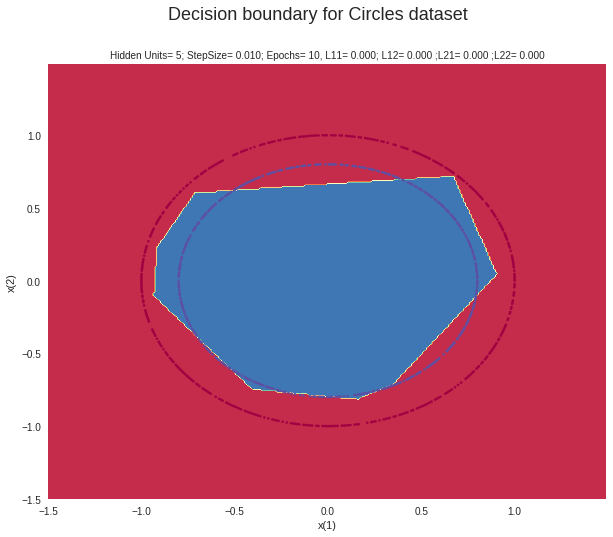

In [239]:

nnetMat3 = NeuralNetworkMat(5, batch_size = 100, n_epochs=10, alpha = .01, lambda11 = 0, lambda12 = 0, lambda21 = 0, lambda22 = 0)
nnetMat3.fit(train_inputs, train_labels) 

print("Train accuracy:",nnetMat3.score(train_inputs, train_labels))
print("Test accuracy:",nnetMat3.score(test_inputs, test_labels))

contour_plot(train_inputs, train_labels, lambda train_inputs: nnetMat3.predict(train_inputs), nnetMat3.hyper_vec)


### Q6. Neural network implementaion using matrix calculus

In [0]:
### matrix implementation

import numpy as np


def softmax(x) : 
    """Compute softmax of the x values"""
    x_max = np.max(x)
    exp_x = np.exp(x - x_max) #Makes softmax Numerically stable
    return exp_x/exp_x.sum()

def logits_exp(X):
    X_max = np.max(X, axis=0, keepdims=True)
    exp_X = np.exp(X - X_max)
    return exp_X / np.sum(exp_X, axis=0, keepdims=True)

class NeuralNetworkMat:
    """Our implementation of a Neural Network using matrix multiplication"""
    
    def __init__(self, dh, alpha=1e-2, tol=1e-3,
                 batch_size=32, n_epochs=500, lambda11=0, 
                 lambda12=0, lambda21=0, lambda22=0):
        self._is_trained = False
        self._dh = dh  #hidden layer size
        self._alpha = alpha 
        self._tol = tol
        self._K = batch_size
        self._n_epochs = n_epochs
        self._l11 = lambda11
        self._l12 = lambda12
        self._l21 = lambda21
        self._l22 = lambda22
        self.hyper_vec = [self._dh, self._alpha, self._n_epochs, self._l11, self._l12, self._l21, self._l22] 


    def _initialise_params(self, d=0, m=0, set_W = 0):
        """Randomly initialize the weights"""
        assert d > 0, "No I/P available"
        assert m > 0, "No labels available"
        self._d = d #I/p dimensions
        self._m = m  #No. of classes  
        self._W1 = np.random.uniform(-(self._d ** (-0.5)), 
                                     self._d ** (-0.5), 
                                     (self._dh, self._d))
        self._W2 = np.random.uniform(-(self._dh ** (-0.5)), 
                                     self._dh ** (-0.5), 
                                     (self._m, self._dh))        
        self._b1 = np.zeros((self._dh, 1))
        self._b2 = np.zeros((self._m, 1))
        
        if set_W ==1:
            
            self._W1 = np.array([[.01,.012],[.003, .0025]])
            self._W2 = np.array([[.001,.029],[.0034, .05]])

    def __str__(self):
        """String representation of the parameters"""
        #assert self._is_trained
        return "b1 = %s, W1 = %s, b2 = %s, W2 = %s" % \
            (
            str(np.round(self._b1, 3)).replace('\n', ''), 
            str(np.round(self._W1, 3)).replace('\n', ''),
            str(np.round(self._b2, 3)).replace('\n', ''),
            str(np.round(self._W2, 3)).replace('\n', '')
            )

    def L(self, X, y):
        """Calculate loss function for multiple entries"""
        n = X.shape[0]
        return \
         -np.log(logits_exp(self._W2 @ np.maximum(self._W1 @ X.T + self._b1, 0) + self._b2)[y, range(n)])

    def predict(self, X):
        """Predicts the classes for the test data"""
        sm = logits_exp(self._W2 @ np.maximum(self._W1 @ X.T + self._b1, 0) + self._b2)
        return np.argmax(sm, axis=0)

    def score(self, X, y):
        return np.sum(self.predict(X) == y) / len(y)

    def fit(self, X, y, verbose=False, valid_test_sets=None, log_file=None):
        """Fit by matrix multiplication"""
        n, d = X.shape
        m = max(1+max(y), 2)
        self._initialise_params(d, m)
        assert X.shape[0] == len(y), "Size mismatch!"
        assert np.all(0 <= y) and np.all(y <= self._m-1), "Check labels!"
        # validation and test sets
        if valid_test_sets is not None:
            # check data integrity
            X_valid, X_test, y_valid, y_test = valid_test_sets
            assert X_valid.shape[0] == len(y_valid), "Size mismatch!"
            assert X_test.shape[0] == len(y_test), "Size mismatch!"
            assert np.all(0 <= y_valid) and np.all(y_valid <= self._m-1), \
                                                                "Check labels!"
            assert np.all(0 <= y_test) and np.all(y_test <= self._m-1), \
                                                                "Check labels!"        
        n_minibatches = 1 + (n // self._K)
        l = 1
        while True:
            # check number of epochs
            if l > self._n_epochs:
                self._is_trained = True
                if verbose:
                    print("Maximum epochs reached. Exiting...")
                break
            # loop over minibatches
            for i in range(n_minibatches):
                # final batch, if exists
                if i*self._K >= n:
                    continue
                # set the current batch
                X_batch = X[i*self._K:(i+1)*self._K]
                y_batch = y[i*self._K:(i+1)*self._K]
                # do fprop and bprop to find gradients
                fprop_params = self._fprop(X_batch, y_batch)  
                grad_b1, grad_W1, grad_b2, grad_W2 = \
                        self._bprop(X_batch, y_batch, fprop_params)
                # store old parameter values
                old_b1, old_W1, old_b2, old_W2 = \
                        self._b1.copy(), self._W1.copy(), \
                        self._b2.copy(), self._W2.copy()
                # do gradient descent with regularization
                self._b1 -= self._alpha \
                                * np.sum(grad_b1, axis=1, keepdims=True)
                self._W1 -= self._alpha \
                                * (grad_W1
                                   + self._l11 * np.sign(self._W1)
                                   + self._l12 * 2 * self._W1)
                self._b2 -= self._alpha \
                                * np.sum(grad_b2, axis=1, keepdims=True)              
                self._W2 -= self._alpha \
                                * (grad_W2 
                                   + self._l21 * np.sign(self._W2)
                                   + self._l22 * 2 * self._W2)
                grad_params = np.hstack([np.sum(grad_b1, axis=1).ravel(), 
                                         grad_W1.ravel(),
                                         np.sum(grad_b2, axis=1).ravel(), 
                                         grad_W2.ravel()])
                # convergence
                if np.sum(grad_params ** 2) < self._tol:
                    self._is_trained = True
                    if verbose:
                        print("Epoch:", l, 
                              "\tAverage Trainin Loss:", np.mean(self.L(X,y)))
                        print("Program converged after epoch", l)
                    break
            # if we have validation and test sets, compute loss and error
            # and write to the log file
            if valid_test_sets is not None:
                tr_loss, vld_loss, tst_loss = \
                                np.mean(self.L(X, y)), \
                                np.mean(self.L(X_valid, y_valid)), \
                                np.mean(self.L(X_test, y_test))
                tr_err, vld_err, tst_err = \
                                1 - self.score(X, y), \
                                1 - self.score(X_valid, y_valid), \
                                1 - self.score(X_test, y_test)
                if log_file is not None:
                    with open(log_file, 'a+') as f:
                        params_str = "Params:%d,%0.3f,%d,%0.3f,%0.3f,%0.3f,%0.3f" % \
                            (self._dh, self._alpha, self._n_epochs,
                             self._l11, self._l12, self._l21, self._l22)
                        epoch_str = "Epoch:%d" % l
                        loss_str = "Average Losses:%0.3f,%0.3f,%0.3f" % \
                            (tr_loss, vld_loss, tst_loss)
                        err_str = "Misclassification Errors:%0.3f,%0.3f,%0.3f" % \
                            (tr_err, vld_err, tst_err)                        
                        f.write(params_str+'\t'+epoch_str+'\t'
                                +loss_str+'\t'+err_str+'\n')
            if verbose:
                if valid_test_sets is None:
                    print("Epoch:", l, 
                          "\nTraining Loss:", np.mean(self.L(X, y)),
                          "\nTraining Error:", 1 - self.score(X, y))
                else:
                    print("Epoch:", l, 
                          "\nTraining Loss:", tr_loss,
                          "\tValidation Loss:", vld_loss,
                          "\tTest Loss:", tst_loss,
                          "\nTraining Error:", tr_err,
                          "\tValidation Error:", vld_err,
                          "\tTest Error:", tst_err)
            if self._is_trained:
                break
            l += 1

    def _fprop(self, X, y):
        """forward propagation"""
        assert X.shape[0] == len(y), "Size mismatch!"
        assert np.all(0 <= y) and np.all(y <= self._m-1), "Check labels!"
        n, d = X.shape
        self._d = d
        ha = np.einsum('ik,jk->ij', self._W1, X) + self._b1 
        hs = np.maximum(ha, 0)
        oa = np.einsum('ik,kj->ij', self._W2, hs) + self._b2
        os = logits_exp(oa)
        return ha, hs, oa, os
        
    def _bprop(self, X, y, fprop_params):
        """backward propagation"""
        ha, hs, oa, os = self._fprop(X, y)
        n, d = X.shape
        eye_mat = np.zeros((self._m, n))
        for j in range(n):
            eye_mat[y[j], j] = 1
        grad_oa = os - eye_mat
        grad_b2 = grad_oa
        grad_W2 = np.einsum('ik,jk->ij', grad_oa, hs)
        grad_hs = np.einsum('ki,kj->ij', self._W2, grad_oa)
        grad_ha = grad_hs * (ha > 0)
        grad_b1 = grad_ha
        grad_W1 = np.einsum('ik,kj->ij', grad_ha, X)
        return grad_b1, grad_W1, grad_b2, grad_W2
      
    def compare_gradients(self, X, y,set_W=0):
        assert X.shape[0] == len(y), "Size mismatch!"
        
        self._initialise_params(X.shape[1],max(max(y)+1,2),set_W)
        
        assert np.all(0 <= y) and np.all(y <= self._m-1), "Check labels!"
        bools = np.zeros(X.shape[0]).astype(np.bool)
        
        ha,hs,oa,os = self._fprop(X,y)
        bp_gr_b1, bp_gr_W1, bp_gr_b2, bp_gr_W2 = \
                    self._bprop(X,y,(ha,hs,oa,os))
        
        
        self.display_gradientsMat(np.sum(bp_gr_b1, axis=1, keepdims=True), bp_gr_W1, 
                                  np.sum(bp_gr_b2, axis=1, keepdims=True), bp_gr_W2)
        return 

    def display_gradientsMat(self, grad_b1, grad_W1, grad_b2, grad_W2):
        print("Gradients values:")
        print("1) b1 gradient: ")
        print("back-propagation method: ")
        print(grad_b1)
        print()
        print("2) W1 gradient: ")
        print("back-propagation method: ")
        print(grad_W1)
        print()
        print("3) b2 gradient: ")
        print("back-propagation method: ")
        print(grad_b2)
        print()
        print("4) W2 gradient: ")
        print("back-propagation method: ")
        print(grad_W2)
        print()

In [250]:
# create train, validation and test sets
from keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
(data, y), (data_test, y_test) = fashion_mnist.load_data()
n1, d1, d2 = data.shape
data = data.reshape(n1, d1*d2)
n2, d1, d2 = data_test.shape
data_test = data_test.reshape(n2, d1*d2)
sc = MinMaxScaler()
sc.fit(data)
X = sc.transform(data)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_test = sc.transform(data_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Following cell has a utility function to help with plotting the decision boundary

Train accuracy: 0.4993939393939394
Test accuracy: 0.5018181818181818


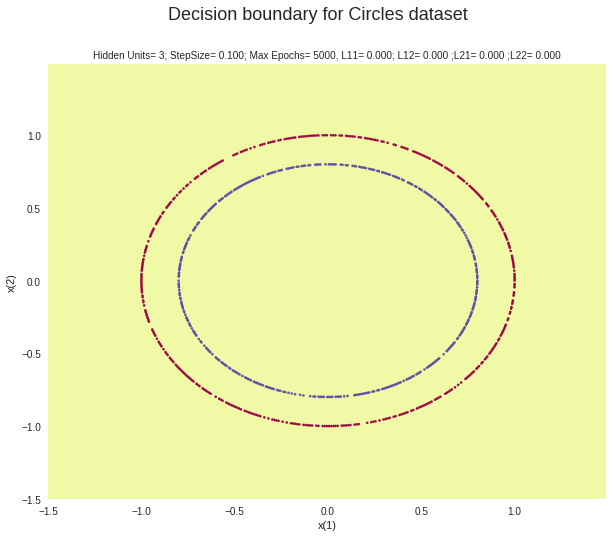

In [113]:
nnet = NeuralNetworkMat(3, batch_size = 100,n_epochs=5e3, alpha = .1, tol = 1e-4)
nnet.fit(train_inputs, train_labels) 

print("Train accuracy:",nnet.score(train_inputs, train_labels))
print("Test accuracy:",nnet.score(test_inputs, test_labels))

contour_plot(train_inputs, train_labels, lambda x: nnet.predict(x),nnet.hyper_vec)


### Compare both implementations (with a loop and with matrix calculus) to check that they both give the same values for the gradients on the parameters, first for K = 1, then for K = 10. Display the gradients for both methods

In [151]:
nnetl = NeuralNetworkLoop(2, batch_size= 1)
nnetl.compare_gradients(train_inputs[5:6], train_labels[5:6],set_W=1)

All ratios >.99 and <1.01: True
Gradients values:
1) b1 gradient: 
back-propagation method: 
[[0.00809991]
 [0.56309461]]
finite difference method: 
[[0.00810945]
 [0.56309797]]

2) W1 gradient: 
back-propagation method: 
[[-0.19432268 -0.17133921]
 [ 0.18087188  0.06738426]]
finite difference method: 
[[-0.1943215  -0.17133078]
 [ 0.18087281  0.06738817]]

3) b2 gradient: 
back-propagation method: 
[[-2.02039145]
 [ 2.02039145]]
finite difference method: 
[[-2.02031798]
 [ 2.02045135]]

4) W2 gradient: 
back-propagation method: 
[[-0.00690957 -0.1179392 ]
 [ 0.00690957  0.1179392 ]]
finite difference method: 
[[-0.00690957 -0.11793899]
 [ 0.00690958  0.11793952]]



True

In [150]:
nnetm = NeuralNetworkMat(2, batch_size= 1)
nnetm.compare_gradients(train_inputs[5:6], train_labels[5:6],set_W=1)

Gradients values:
1) b1 gradient: 
back-propagation method: 
[[0.]
 [0.]]

2) W1 gradient: 
back-propagation method: 
[[0. 0.]
 [0. 0.]]

3) b2 gradient: 
back-propagation method: 
[[-0.5]
 [ 0.5]]

4) W2 gradient: 
back-propagation method: 
[[0. 0.]
 [0. 0.]]



0

In [155]:
nnetl = NeuralNetworkLoop(2, batch_size= 10)
nnetl.compare_gradients(train_inputs[:10], train_labels[:10],set_W=1)

nnetm = NeuralNetworkMat(2, batch_size= 10)

nnetm.compare_gradients(train_inputs[:10], train_labels[:10],set_W=1)

All ratios >.99 and <1.01: True
Gradients values:
1) b1 gradient: 
back-propagation method: 
[[4.95415414e-08]
 [1.05004761e-02]]
finite difference method: 
[[4.95847378e-08]
 [1.05004900e-02]]

2) W1 gradient: 
back-propagation method: 
[[ 0.00046115  0.00042752]
 [ 0.01152306 -0.00361996]]
finite difference method: 
[[ 0.00046115  0.00042752]
 [ 0.01152306 -0.00361995]]

3) b2 gradient: 
back-propagation method: 
[[-2.00002267]
 [ 2.00002267]]
finite difference method: 
[[-1.99995353]
 [ 2.00006182]]

4) W2 gradient: 
back-propagation method: 
[[-0.00405906 -0.0012152 ]
 [ 0.00405906  0.0012152 ]]
finite difference method: 
[[-0.00405906 -0.0012152 ]
 [ 0.00405906  0.0012152 ]]

Gradients values:
1) b1 gradient: 
back-propagation method: 
[[4.95415414e-08]
 [1.05004761e-02]]

2) W1 gradient: 
back-propagation method: 
[[ 0.00046115  0.00042752]
 [ 0.01152306 -0.00361996]]

3) b2 gradient: 
back-propagation method: 
[[-2.00002267]
 [ 2.00002267]]

4) W2 gradient: 
back-propagation met

0

### Time how long takes an epoch on fashion MNIST for K = 100 for both versions (loop over a minibatch and matrix calculus).


In [157]:
%%time
nnetl = NeuralNetworkLoop(2, batch_size= 100,n_epochs=1)
nnetl.fit_loop(X_train,y_train)

0 .LOSS: 2.2967986095893047
maximum epochs reached. Exiting...
CPU times: user 11.6 s, sys: 419 ms, total: 12.1 s
Wall time: 11.5 s


In [159]:
%%time
nnetm = NeuralNetworkMat(2, batch_size= 100, n_epochs =1)
nnetm.fit(X_train, y_train)

CPU times: user 446 ms, sys: 0 ns, total: 446 ms
Wall time: 453 ms


### Hyperparameter selection

In [0]:
hyperparams = [(dh, alpha, n_epoch, l11, l12, l21, l22) 
               for dh in [100, 200, 400]
               for alpha in [0.01, 0.005]
               for n_epoch in [1, 4, 7, 10]
               for l11 in [0, 0.1, 1]
               for l12 in [0, 0.1, 1]
               for l21 in [0, 0.1, 1]
               for l22 in [0, 0.1, 1]]
select_hyperparams = [hyperparams[i] for i in 
                      np.random.choice(len(hyperparams), 50, replace=False)]
%%time
for (dh, alpha, n_epochs, l11, l12, l21, l22) in select_hyperparams:
    nnet = NeuralNetworkMat(dh=dh, alpha=alpha, tol=1e-6, n_epochs=n_epochs, 
                            batch_size=100, lambda11=l11, lambda12=l12, 
                            lambda21=l21, lambda22=l22)
    nnet.fit(X_train, y_train, verbose=True, log_file='results.txt',
             valid_test_sets=(X_valid, X_test, y_valid, y_test))

### Error and loss plots for optimal parameters

In [47]:
%%time
nnet = NeuralNetworkMat(50, alpha=0.005, tol=1e-6, n_epochs=25, 
                        batch_size=100, lambda11=0.001, lambda12=0.001, 
                        lambda21=0.001, lambda22=0.001)
nnet.fit(X_train, y_train, verbose=True, log_file='results.txt',
         valid_test_sets=(X_valid, X_test, y_valid, y_test))

Epoch: 1 
Training Loss: 0.5022299270432927 	Validation Loss: 0.5155462157001616 	Test Loss: 0.5405232664805949 
Training Error: 0.18685416666666665 	Validation Error: 0.1911666666666667 	Test Error: 0.20030000000000003
Epoch: 2 
Training Loss: 0.4511475266964961 	Validation Loss: 0.4647232741367605 	Test Loss: 0.500704064421554 
Training Error: 0.16841666666666666 	Validation Error: 0.17374999999999996 	Test Error: 0.18310000000000004
Epoch: 3 
Training Loss: 0.431423664380617 	Validation Loss: 0.453239074540906 	Test Loss: 0.4861816380557 
Training Error: 0.15808333333333335 	Validation Error: 0.1648333333333334 	Test Error: 0.17210000000000003
Epoch: 4 
Training Loss: 0.43161855835776813 	Validation Loss: 0.45464692082827696 	Test Loss: 0.4936273784029072 
Training Error: 0.15660416666666666 	Validation Error: 0.16525 	Test Error: 0.17259999999999998
Epoch: 5 
Training Loss: 0.41284039439728437 	Validation Loss: 0.43932378277905376 	Test Loss: 0.4743555590358872 
Training Error: 0.1

In [0]:
import pandas as pd
df = pd.read_csv('results.txt', sep='\t', header=None, 
                 names=['Params', 'Epoch', 'Losses', 'Errors'])

In [49]:
df.head(2)

,Params,Epoch,Losses,Errors
0,"Params:50,0.005,25,0.001,0.001,0.001,0.001",Epoch:1,"Average Losses:0.502,0.516,0.541","Misclassification Errors:0.187,0.191,0.200"
1,"Params:50,0.005,25,0.001,0.001,0.001,0.001",Epoch:2,"Average Losses:0.451,0.465,0.501","Misclassification Errors:0.168,0.174,0.183"


In [0]:
losses = df.Losses.apply(lambda x: [float(s) for s in x.split(':')[1].split(',')]).tolist()
errors = df.Errors.apply(lambda x: [float(s) for s in x.split(':')[1].split(',')]).tolist()

In [0]:
train_losses = [e[0] for e in losses]
vld_losses = [e[1] for e in losses]
tst_losses = [e[2] for e in losses]
train_errors = [e[0] for e in errors]
vld_errors = [e[1] for e in errors]
tst_errors = [e[2] for e in errors]



In [0]:
import matplotlib.pyplot as plt

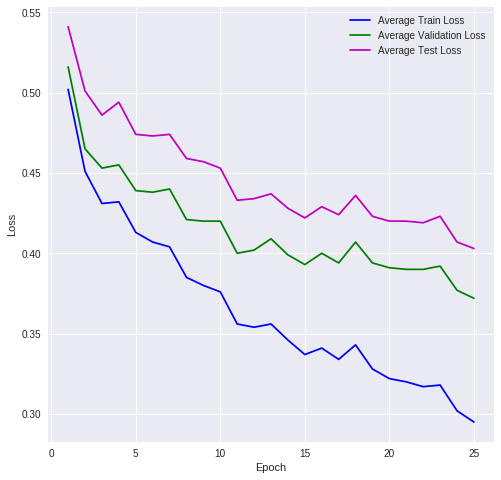

In [53]:
plt.figure(figsize=(8,8))
plt.plot(range(1, 26), train_losses, 'b-', label='Average Train Loss')
plt.plot(range(1, 26), vld_losses, 'g-', label='Average Validation Loss')
plt.plot(range(1, 26), tst_losses, 'm-', label='Average Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

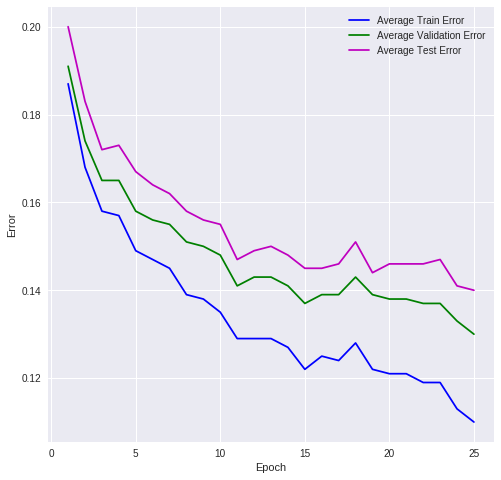

In [57]:
plt.figure(figsize=(8,8))
plt.plot(range(1, 26), train_errors, 'b-', label='Average Train Error')
plt.plot(range(1, 26), vld_errors, 'g-', label='Average Validation Error')
plt.plot(range(1, 26), tst_errors, 'm-', label='Average Test Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()